In [2]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,SimpleRNN
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model, set_random_seed
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [3]:
set_random_seed(66)

In [4]:
def fetch_and_clean_stock_data(ticker, start_date, end_date, file_name='stock_data.csv'):
    """
    Fetch stock data for the given ticker from Yahoo Finance, using the provided start date
    and the current date as the end date.
    Saves the data to a CSV file and downloads it.

    Args:
    - ticker (str): Stock ticker symbol (e.g., 'TSLA').
    - start_date (str): Start date for fetching data in 'YYYY-MM-DD' format.
    - end_date (str): End date for fetching data in 'YYYY-MM-DD' format.
    - file_name (str): Name of the CSV file to save the data. Default is 'stock_data.csv'.

    Returns:
    - data (DataFrame): The stock data fetched from Yahoo Finance.
    """
    # Fetch data from Yahoo Finance
    data = yf.download(ticker, start=start_date, end=end_date)

    # If the data has a multi-level column index, drop the second level
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)

    # Rename the columns for better readability
    data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

    # Drop NaN rows
    data = data.dropna()

    # Save the data to a CSV file
    data.to_csv(file_name)

    # Download the CSV file (for Google Colab compatibility)
    try:
        from google.colab import files
        files.download(file_name)
        print(f"Data for {ticker} saved to {file_name} and downloaded.")
    except ImportError:
        print(f"Data for {ticker} saved to {file_name}. No download as this isn't Google Colab.")

    # Return the DataFrame
    return data
# Fetch data for Tesla and JPMorgan
data_tesla = fetch_and_clean_stock_data(
    ticker='TSLA',
    start_date="2014-09-19",
    end_date="2024-09-19",
    file_name='tesla_stock_data_with_returns.csv'
)

data = fetch_and_clean_stock_data(
    ticker='JPM',
    start_date="2014-09-19",
    end_date="2024-09-19",
    file_name='jpm_stock_data_with_returns.csv'
)


[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed

Data for TSLA saved to tesla_stock_data_with_returns.csv and downloaded.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data for JPM saved to jpm_stock_data_with_returns.csv and downloaded.


# **DATA** **PREPROCESSING**

In [5]:
# Taking a quick look at our Dataset JP MORGAN
data.head()
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-12,205.341675,206.600006,208.779999,204.889999,207.649994,9055800
2024-09-13,203.075562,204.320007,207.850006,203.020004,206.860001,10226700
2024-09-16,206.593994,207.860001,208.210007,205.589996,205.830002,8634900
2024-09-17,207.975525,209.250000,209.929993,207.660004,207.729996,7573300
2024-09-18,206.265991,207.529999,211.339996,206.699997,209.009995,8259900


In [6]:
# Taking a quick look at our Dataset TESLA
data_tesla.head()
data_tesla.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-12,229.809998,229.809998,231.449997,223.830002,224.660004,72020000
2024-09-13,230.289993,230.289993,232.669998,226.320007,228.000000,59515100
2024-09-16,226.779999,226.779999,229.960007,223.529999,229.300003,54323000
2024-09-17,227.869995,227.869995,234.570007,226.550003,229.449997,66761600
2024-09-18,227.199997,227.199997,235.679993,226.880005,230.089996,78010200


In [7]:
# View the data types and non-null values in the dataset
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-09-19 to 2024-09-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
# Doing some descriptive stats to understand the central tendancies
# and variabilities of the Data
print('JP MORGAN  Statistical value')
data.describe()


JP MORGAN  Statistical value


,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,101.125005,113.663621,114.696725,112.593526,113.638394,1.412683e+07
std,41.444098,38.485472,38.786621,38.149586,38.456315,6.528012e+06
min,41.518143,53.070000,53.910000,50.070000,53.900002,3.220500e+06
25%,70.143864,86.715000,87.177500,85.857502,86.430000,9.869775e+06
50%,93.914101,110.965000,111.890003,109.845001,110.990002,1.274160e+07
75%,132.535027,139.580002,140.715004,138.212505,139.570000,1.645210e+07
max,223.430817,224.800003,225.479996,221.929993,222.500000,5.619230e+07


In [9]:
# Doing some descriptive stats to understand the central tendancies
# and variabilities of the Data
print('Tesla Statistical value')
data_tesla.describe()

Tesla Statistical value


,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,107.142733,107.142733,109.523028,104.667384,107.169883,1.122561e+08
std,109.365515,109.365515,111.898320,106.794317,109.458746,7.411750e+07
min,9.578000,9.578000,10.331333,9.403333,9.488000,1.062000e+07
25%,16.702667,16.702667,16.933332,16.465666,16.693166,6.678508e+07
50%,23.702000,23.702000,24.068000,23.396000,23.735333,9.289395e+07
75%,211.875004,211.875004,216.714996,206.374996,210.616673,1.299176e+08
max,409.970001,409.970001,414.496674,405.666656,411.470001,9.140820e+08


In [10]:
# Check for missing values
print(data.isnull().sum())
print('check tesla missing value')
print(data_tesla.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
check tesla missing value
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [11]:
def check_data_quality(data):
    """
    Checks the DataFrame for duplicate and missing values.

    Parameters:
    - data (pandas.DataFrame): The dataset to check.

    Returns:
    - None: Prints the results of the checks.
    """
    # Check for duplicates
    duplicates = data.duplicated()
    if duplicates.any():
        print("The DataFrame has duplicates.")
        print(f"Number of duplicate rows: {duplicates.sum()}")
    else:
        print("The DataFrame does not have duplicates.")
    print("\n" + "="*50 + "\n")

    # Check for missing values
    missing_values = data.isnull().sum()
    print("Missing Values:")
    print(missing_values)
    print("\n" + "="*50 + "\n")

# Example usage
check_data_quality(data_tesla)  # Call the function with Tesla data
check_data_quality(data)    # Call the function with JPMorgan data

The DataFrame does not have duplicates.


Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


The DataFrame does not have duplicates.


Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64




In [12]:
# Outlier detection
close_prices = data['Close']

# Calculate daily returns
daily_returns = close_prices.pct_change()
# Calculating z-scores for each data point
z_scores = (daily_returns - daily_returns.mean()) / daily_returns.std()
# Set a threshold for identifying outliers
threshold = 3
# Identify outliers
outliers = z_scores[abs(z_scores) > threshold]
"""# Remove outliers from the 'data' DataFrame
data = data[data.index.isin(outliers.index) == False]"""
print(data)




                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-19   46.047894   61.110001   61.849998   60.980000   61.740002   
2014-09-22   45.897194   60.910000   61.450001   60.799999   60.939999   
2014-09-23   45.919792   60.939999   61.400002   60.770000   60.820000   
2014-09-24   46.439720   61.630001   61.639999   61.020000   61.180000   
2014-09-25   45.324505   60.150002   61.500000   60.150002   61.490002   
...                ...         ...         ...         ...         ...   
2024-09-12  205.341675  206.600006  208.779999  204.889999  207.649994   
2024-09-13  203.075562  204.320007  207.850006  203.020004  206.860001   
2024-09-16  206.593994  207.860001  208.210007  205.589996  205.830002   
2024-09-17  207.975525  209.250000  209.929993  207.660004  207.729996   
2024-09-18  206.265991  207.529999  211.339996  206.699997  209.009995   

              Volume  
Date          

# **EXPLORATORY** **DATA** **ANALYSIS**

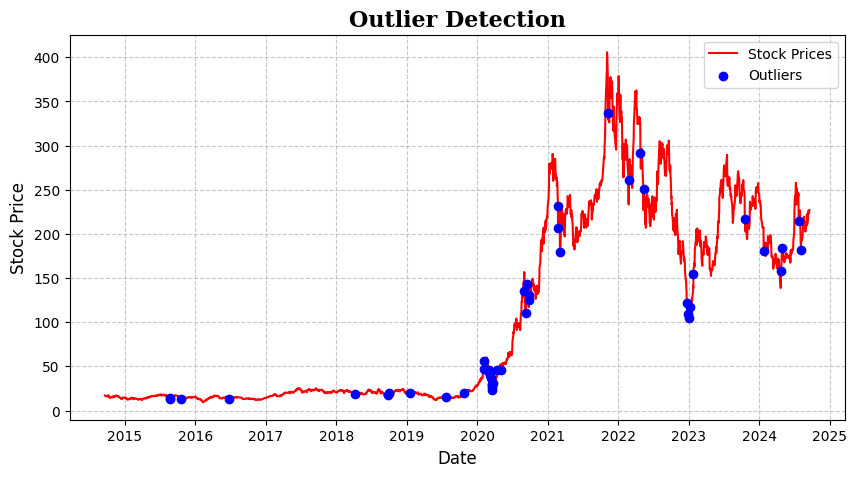

Number of outliers: 46


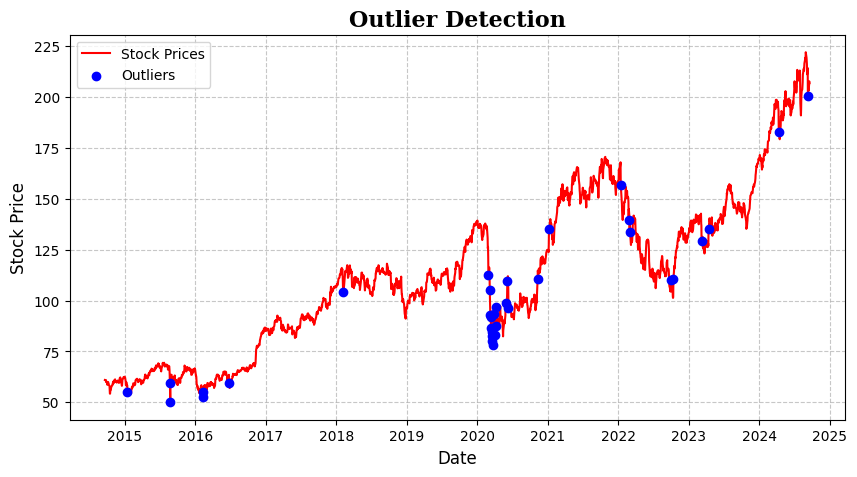

Number of outliers: 35


In [13]:
def plot_outliers(data, column='Close', threshold=3):
    """
    Plots stock prices with identified outliers and displays the number of outliers.

    Parameters:
    - data (pandas.DataFrame): The dataset containing the column.
    - column (str): The column name to analyze (default is 'Close').
    - threshold (float): The z-score threshold to identify outliers (default is 3).

    Returns:
    - None
    """
    # Calculate daily returns
    close_prices = data[column]
    daily_returns = close_prices.pct_change()

    # Calculate z-scores for daily returns
    z_scores = (daily_returns - daily_returns.mean()) / daily_returns.std()

    # Identify outliers based on the threshold
    outliers = z_scores[abs(z_scores) > threshold]

    # Plot stock prices with outliers
    plt.figure(figsize=(10, 5))
    plt.plot(close_prices.index, close_prices.values, label='Stock Prices', color='red')
    plt.scatter(outliers.index, close_prices[outliers.index], color='blue', label='Outliers', zorder=5)
    plt.title('Outlier Detection', fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print(f"Number of outliers: {len(outliers)}")

# function call outliers
plot_outliers(data_tesla, column='Close', threshold=3)
plot_outliers(data, column='Close', threshold=3)

In [14]:
# Extract the 'open' prices from the DataFrame
df2 = data.reset_index()['Open']
df2

,Open
0,46.047894
1,45.897194
2,45.919792
3,46.439720
4,45.324505
...,...
2511,205.341675
2512,203.075562
2513,206.593994
2514,207.975525


**OPENING** **PRICE** **PLOT**

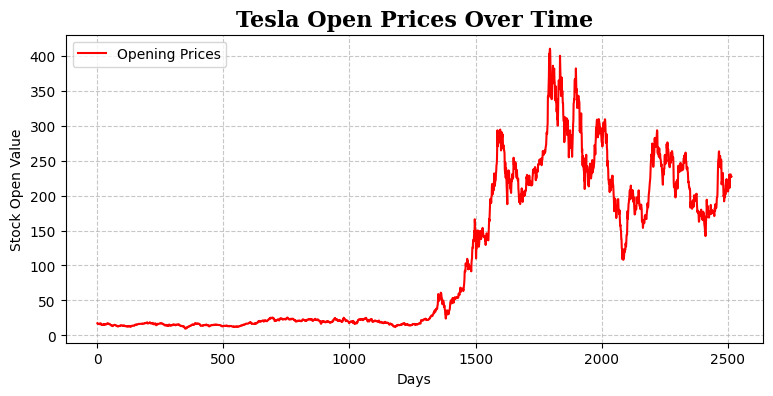

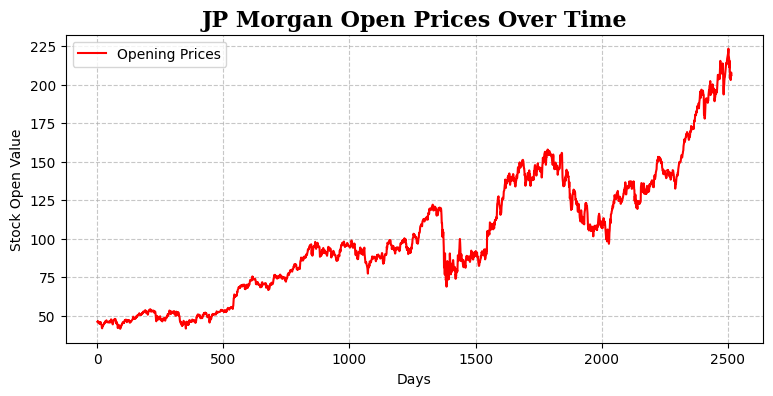

In [15]:
def plot_opening_prices(data, company_name):
    """
    Plots the opening prices of a stock to inspect trends.

    Parameters:
    - data: Pandas Series containing opening prices.
    - company_name: String representing the company name for plot labeling.

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    plt.plot(data, color='r', label='Opening Prices')
    plt.xlabel('Days')
    plt.ylabel('Stock Open Value')
    plt.title(f"{company_name} Open Prices Over Time", fontsize=16, fontweight='bold', fontfamily='serif')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=10)
    plt.show()

# Extract 'Open' prices for Tesla and JP Morgan from their respective DataFrames
tesla_open_prices = data_tesla.reset_index()['Open']
jpm_open_prices = data.reset_index()['Open']

# Example function calls
plot_opening_prices(tesla_open_prices, 'Tesla')
plot_opening_prices(jpm_open_prices, 'JP Morgan')

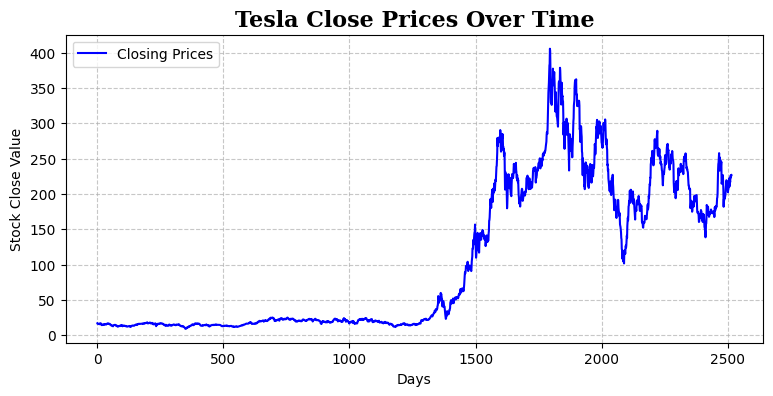

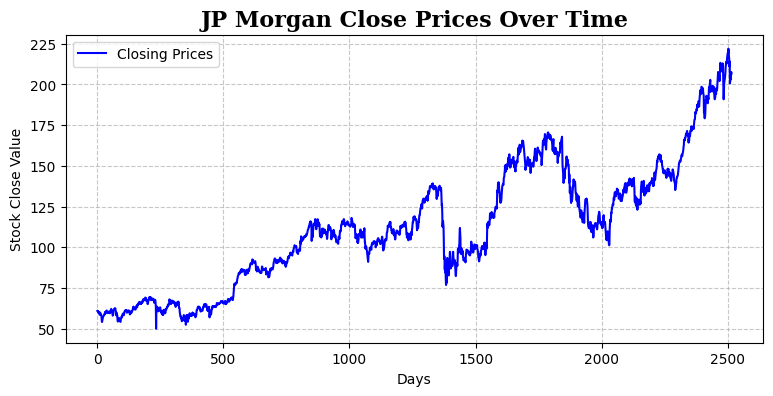

In [16]:
def plot_closing_prices(data, company_name):
    """
    Plots the closing prices of a stock to inspect trends.

    Parameters:
    - data: Pandas Series containing closing prices.
    - company_name: String representing the company name for plot labeling.

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    plt.plot(data, color='b', label='Closing Prices')
    plt.xlabel('Days')
    plt.ylabel('Stock Close Value')
    plt.title(f"{company_name} Close Prices Over Time", fontsize=16, fontweight='bold', fontfamily='serif')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=10)
    plt.show()

# Extract 'Close' prices for Tesla and JP Morgan from their respective DataFrames
tesla_close_prices = data_tesla.reset_index()['Close']
jpm_close_prices = data.reset_index()['Close']

# Example function calls for closing prices
plot_closing_prices(tesla_close_prices, 'Tesla')
plot_closing_prices(jpm_close_prices, 'JP Morgan')

**CLOSING** **PRICE** **PLOT**

**VOLATILITY** **PLOT**

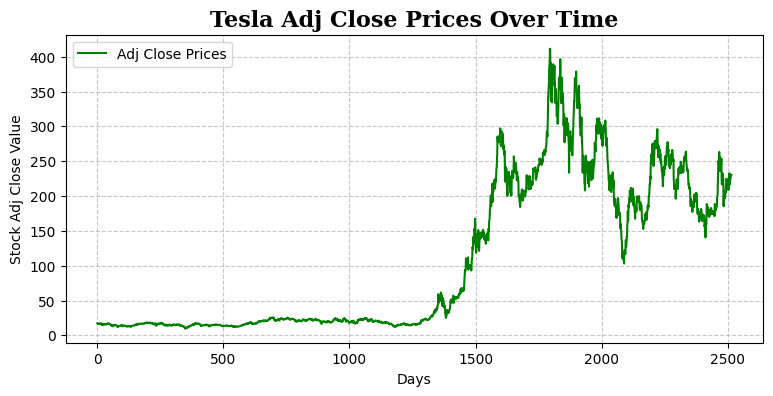

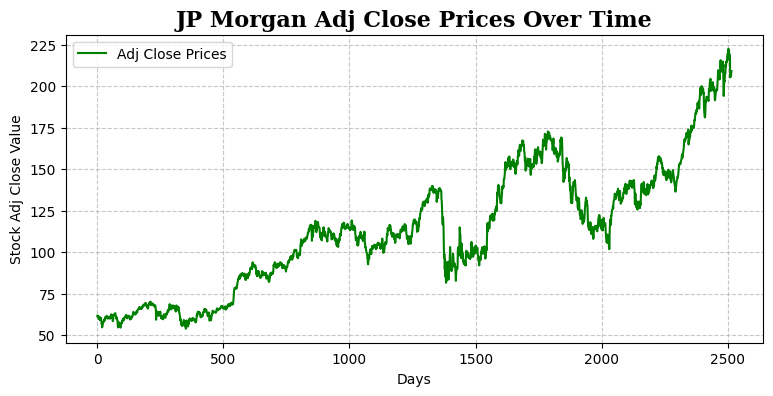

In [17]:
def plot_adj_closing_prices(data, company_name):
    """
    Plots the adjusted closing prices of a stock to inspect trends.

    Parameters:
    - data: Pandas Series containing adjusted closing prices.
    - company_name: String representing the company name for plot labeling.

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    plt.plot(data, color='g', label='Adj Close Prices')
    plt.xlabel('Days')
    plt.ylabel('Stock Adj Close Value')
    plt.title(f"{company_name} Adj Close Prices Over Time", fontsize=16, fontweight='bold', fontfamily='serif')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=10)
    plt.show()

# Extract 'Adj Close' prices for Tesla and JP Morgan from their respective DataFrames
tesla_adj_close_prices = data_tesla.reset_index()['Adj Close']
jpm_adj_close_prices = data.reset_index()['Adj Close']

# Example function calls for adjusted closing prices
plot_adj_closing_prices(tesla_adj_close_prices, 'Tesla')
plot_adj_closing_prices(jpm_adj_close_prices, 'JP Morgan')


**STOCK** **PERFORMANCE** **AND** **VOLUME** **OVER** **TIME**

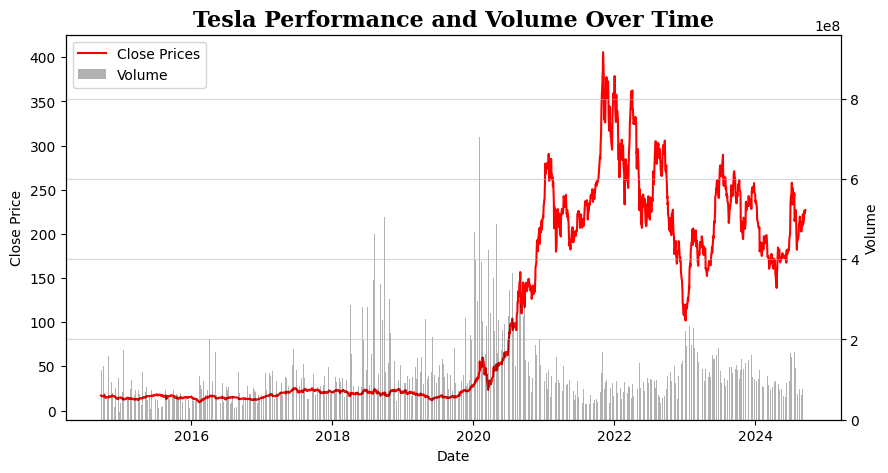

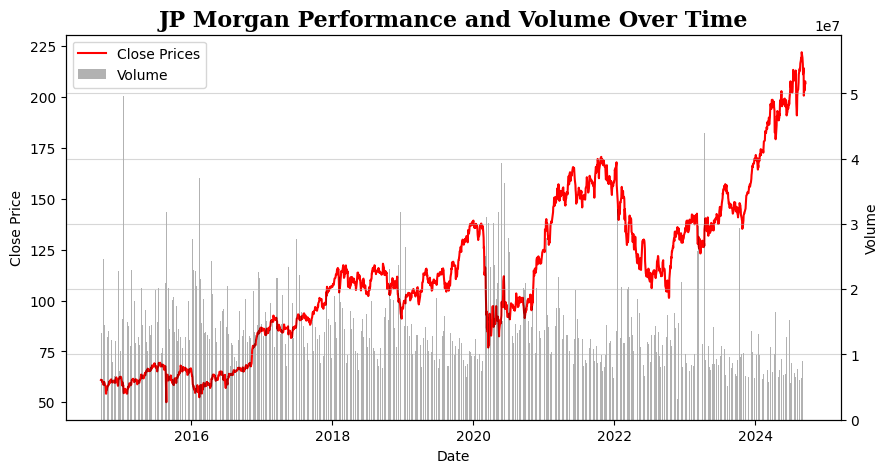

In [18]:
#Function to plot stock performance and volume
def plot_stock_volume(data, stock_name='Stock'):
    """
    Plots the stock performance and volume over time.

    Parameters:
    - data (pandas.DataFrame): The dataset containing 'Close' prices and 'Volume'.
    - stock_name (str): The name of the stock for labeling.

    Returns:
    - None
    """
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot 'Close' prices on the first y-axis
    ax1.plot(data.index, data['Close'], label='Close Prices', color='red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Create second y-axis for volume data
    ax2 = ax1.twinx()
    ax2.bar(data.index, data['Volume'], label='Volume', color='black', alpha=0.3)
    ax2.set_ylabel('Volume', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Title and legend
    plt.title(f'{stock_name} Performance and Volume Over Time', fontsize=16, fontweight='bold', fontfamily='serif')
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax1.legend(lines, labels, loc='upper left')
    plt.grid(alpha=0.5)
    plt.show()

# Example function calls
plot_stock_volume(data_tesla, 'Tesla')
plot_stock_volume(data, 'JP Morgan')

**MIN** **MAX** **SCALING**

In [19]:
# Scale the data to a range between 0 and 1 as LSTMs are sensitive to scale
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
scaled_data_tesla = scaler.fit_transform(data_tesla['Close'].values.reshape(-1,1))

**TIME** **SERIES** **GENERATOR**

In [20]:
# Create the time series data structure
look_back = 50
train_size = int(len(scaled_data_tesla) * 0.80)
train_data = scaled_data_tesla[:train_size]
test_data = scaled_data_tesla[train_size - look_back:]

train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)

**NUMPY** **ARRAY** **CREATION**

In [21]:
def create_dataset(dataset, time_step = 1):
  """
  Create sequences of 'time_step' consecutive values from the input time
  series 'dataset'.
  Parameters:
  - dataset (numpy.ndarray): Input time series data.
  - time_step (int): Number of consecutive time steps in each sequence.
  Returns:
  - numpy.ndarray, numpy.ndarray: Tuple containing dataX and dataY.
  """
  dataX,dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX),np.array(dataY)

**SPLITTING** **DATA**

In [22]:
# Call the function to split the data into input-output datasets
# with a time step of 50
time_step = 50
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [23]:
# Display the shapes of the training and testing datasets
print(X_train.shape)
print(X_test.shape)

(1961, 50)
(503, 50)


# **LONG** **SHORT**-**TERM** **MEMORY**(**LSTM**)

In [24]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile and fit LSTM model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
lstm_model.fit(train_generator, epochs=50, batch_size=32,
               validation_data=(X_test, Y_test))

Epoch 1/50
 1/99 ━━━━━━━━━━━━━━━━━━━━ 7:03 4s/step - loss: 1.2036e-04

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - loss: 0.0279 - val_loss: 0.0042
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - loss: 0.0014 - val_loss: 0.0178
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - loss: 0.0031 - val_loss: 0.0056
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - loss: 0.0011 - val_loss: 0.0090
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 12/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/ste

In [26]:

def build_rnn_model(input_shape):
    """
    Builds a Simple RNN-based model for time series prediction.

    Parameters:
    - input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    - model (Sequential): Compiled RNN model.
    """
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(128, return_sequences=True, input_shape=input_shape))
    rnn_model.add(SimpleRNN(64, return_sequences=True))
    rnn_model.add(SimpleRNN(32))
    rnn_model.add(Dense(1))  # Output layer for regression task

    # Compile the model
    rnn_model.compile(loss='mean_squared_error', optimizer='adam')
    return rnn_model


In [27]:
#Build and train the RNN model
input_shape = (train_generator.length, 1)  # Assuming univariate time series
rnn_model = build_rnn_model(input_shape)

# Train the RNN model
history = rnn_model.fit(
    train_generator,
    epochs=20,
    batch_size=32,
    validation_data=test_generator,
    verbose=1
)


Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.2953 - val_loss: 0.0035
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0034 - val_loss: 0.0081
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0028 - val_loss: 8.9331e-04
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 5.1290e-04 - val_loss: 9.9555e-04
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0018 - val_loss: 0.0069
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0024 - val_loss: 7.0482e-04
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 71m

In [28]:
from tensorflow.keras.layers import GRU, Dense

# Build the GRU model
def build_gru_model(input_shape):
    """
    Builds a GRU-based RNN model for time series prediction.

    Parameters:
    - input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    - model (Sequential): Compiled GRU model.
    """
    gru_model = Sequential()
    gru_model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    gru_model.add(GRU(64, return_sequences=True))
    gru_model.add(GRU(32))
    gru_model.add(Dense(1))  # Output layer for regression task

    # Compile the model
    gru_model.compile(loss='mean_squared_error', optimizer='adam')
    return gru_model

In [29]:
# Example: Build and train the GRU model
input_shape = (train_generator.length, 1)  # Assuming univariate time series
gru_model = build_gru_model(input_shape)

# Train the GRU model
gru_model.fit(train_generator, epochs=20, batch_size=32, validation_data=test_generator)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - loss: 0.0271 - val_loss: 0.0015
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 6.3388e-04 - val_loss: 0.0024
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - loss: 8.4235e-04 - val_loss: 9.8081e-04
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - loss: 7.5214e-04 - val_loss: 8.6096e-04
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - loss: 3.4706e-04 - val_loss: 7.2661e-04
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 316ms/step - loss: 0.0012 - val_loss: 8.4157e-04
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - loss: 4.2048e-04 - val_loss: 6.3200e-04
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - loss: 3.9568e-04 - val_loss: 6.0491e-04
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - loss: 3.5131e-04 - val_loss: 6.2402e-04
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 2.8474e-04 - val_loss: 5.7605e-04
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - loss: 5.3

In [30]:
# Predicting on the dataset with our models
rnn_predictions = rnn_model.predict(test_generator)
lstm_predictions = lstm_model.predict(test_generator)
gru_predictions = gru_model.predict(test_generator)

# Inverting out models
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)

actual_prices = scaler.inverse_transform(test_data[look_back:])

504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step


In [31]:
vals1 = Y_test.reshape(-1, 1)
actual_values = scaler.inverse_transform(vals1)

**MSE**,**MAE** **AND** **RMSE** **OF** **LSTM** **AND** **RNN** **GRU** **MODELS**

In [32]:

def calculate_model_errors(actual_values, predictions):
    """
    Calculates MSE, MAE, and RMSE of the models.

    Parameters:
    - actual_values: NumPy array containing the actual values
    - predictions: NumPy array containing the predicted values

    Returns:
    - tuple: (mse, mae, rmse)
      - mse: Mean Squared Error
      - mae: Mean Absolute Error
      - rmse: Root Mean Squared Error
    """
    # Calculate MSE
    mse = mean_squared_error(actual_values, predictions[:-1])

    # Calculate MAE
    mae = np.mean(np.abs(actual_values - predictions[:-1]))

    # Calculate RMSE
    rmse = np.sqrt(mse)

    return mse, mae, rmse

#  function call
rnn_mse, rnn_mae, rnn_rmse = calculate_model_errors(actual_values, rnn_predictions)
lstm_mse, lstm_mae, lstm_rmse = calculate_model_errors(actual_values, lstm_predictions)
gru_mse, gru_mae, gru_rmse = calculate_model_errors(actual_values, gru_predictions)

print(f'Mean Squared Error of RNN Model: {rnn_mse}')
print(f'Mean Absolute Error of RNN Model: {rnn_mae}')
print(f'Root Mean Squared Error of RNN Model: {rnn_rmse}')

print(f'Mean Squared Error of LSTM Model: {lstm_mse}')
print(f'Mean Absolute Error of LSTM Model: {lstm_mae}')
print(f'Root Mean Squared Error of LSTM Model: {lstm_rmse}')

print(f'Mean Squared Error of GRU Model: {gru_mse}')
print(f'Mean Absolute Error of GRU Model: {gru_mae}')
print(f'Root Mean Squared Error of GRU Model: {gru_rmse}')

Mean Squared Error of RNN Model: 929.1764503074705
Mean Absolute Error of RNN Model: 28.73658673568938
Root Mean Squared Error of RNN Model: 30.482395744223755
Mean Squared Error of LSTM Model: 79.47786403415601
Mean Absolute Error of LSTM Model: 6.946137612193054
Root Mean Squared Error of LSTM Model: 8.915035840318087
Mean Squared Error of GRU Model: 72.55202733160891
Mean Absolute Error of GRU Model: 6.514241910596965
Root Mean Squared Error of GRU Model: 8.517747785160635


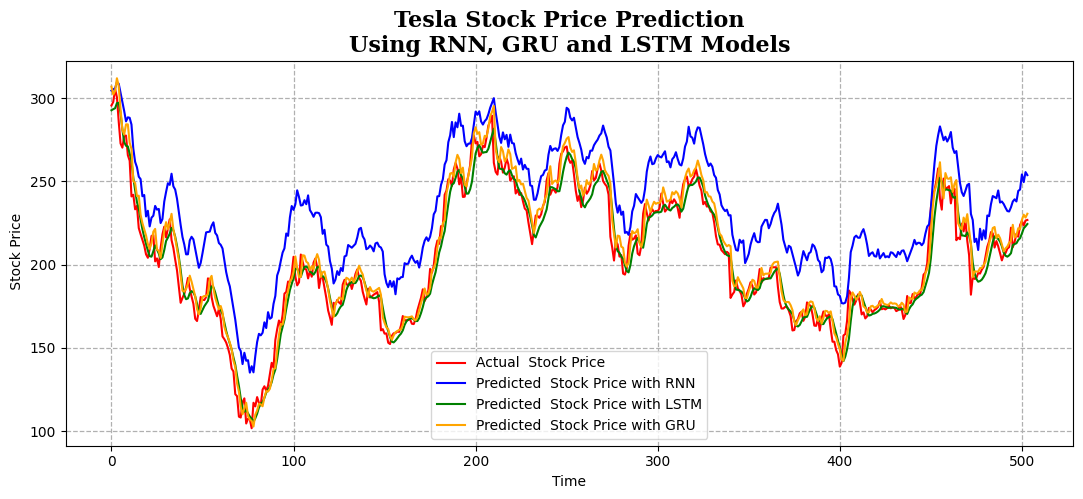

In [33]:
def plot_predictions(true_data, rnn_predictions, lstm_predictions,gru_predictions,stock_name='Stock'):
    """
    Plots the true data along with predictions from RNN and LSTM models.

    Parameters:
    - true_data: Pandas Series or NumPy array containing the true data
    - rnn_predictions: Pandas Series or NumPy array containing the predictions from RNN model
    - lstm_predictions: Pandas Series or NumPy array containing the predictions from LSTM model
    - gru_predictions: Pandas Series or NumPy array containing the predictions from GRU model

    Returns:
    - None
    """
    plt.figure(figsize=(13, 5))
    plt.plot(true_data, color='red', label='Actual  Stock Price')
    plt.plot(rnn_predictions, color='blue', label='Predicted  Stock Price with RNN')
    plt.plot(lstm_predictions, color='green', label='Predicted  Stock Price with LSTM')
    plt.plot(gru_predictions, color='orange', label='Predicted  Stock Price with GRU')
    # Title, labels, and legend
    plt.title(f'{stock_name} Stock Price Prediction\nUsing RNN, GRU and LSTM Models', fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel(' Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()

    # Saving the plot
    plt.savefig('stock_price_prediction_RNN_LSTM.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

# Example function call with actual data
# Replace actual_prices, rnn_predictions, and lstm_predictions with your actual data
plot_predictions(actual_prices, rnn_predictions, lstm_predictions,gru_predictions,'Tesla')

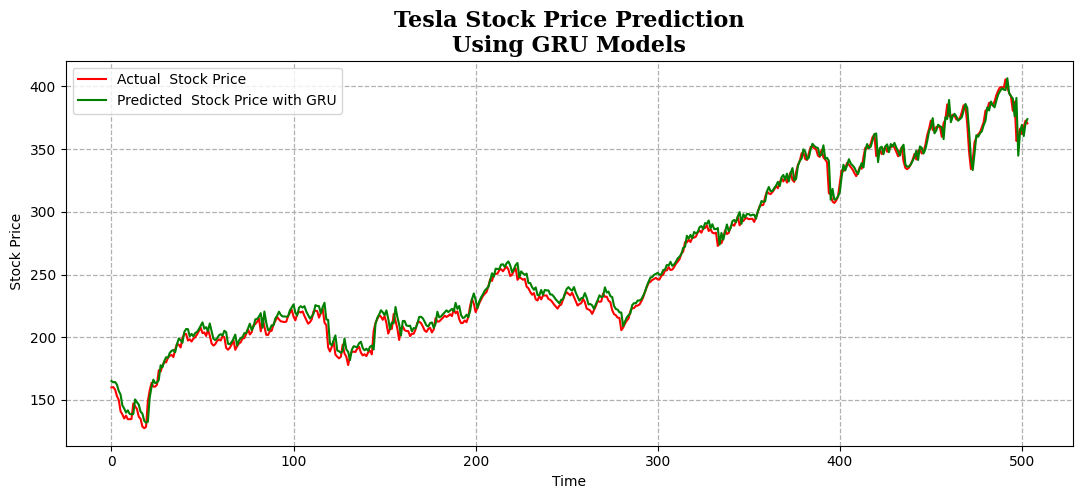

In [52]:
def plot_predictions(true_data, gru_predictions,stock_name='Stock'):
    """
    Plots the true data along with predictions from RNN and LSTM models.

    Parameters:
    - true_data: Pandas Series or NumPy array containing the true data

    - lstm_predictions: Pandas Series or NumPy array containing the predictions from GRU model


    Returns:
    - None
    """
    plt.figure(figsize=(13, 5))
    plt.plot(true_data, color='red', label='Actual  Stock Price')

    plt.plot(gru_predictions, color='green', label='Predicted  Stock Price with GRU')

    # Title, labels, and legend
    plt.title(f'{stock_name} Stock Price Prediction\nUsing GRU Models', fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel(' Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()

    # Saving the plot
    plt.savefig('stock_price_prediction_GRU.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

# Example function call with actual data
# Replace actual_prices, rnn_predictions, and lstm_predictions with your actual data
plot_predictions(actual_prices, gru_predictions,'Tesla')

Finded that LSTM have less error comparing with other 2 models.so predicting the next 30 days of TESLA stock using LSTM model.

**FORECASTING**

In [34]:
def pred_future_stock(model, base_data, days_to_predict,
                      scaler, look_back=2000):
  """
  Predict future stock values using the given LSTM 'model'.
  Parameters:
  - model: Trained LSTM model.
  - base_data: Time series data used as the starting point for prediction.
  - days_to_predict: Number of future days to predict.
  - scaler: Scaler used for data normalization.
  - look_back: Number of past days to consider for each prediction.
  Returns:
  - numpy.ndarray: Predicted future stock values.
  """
  # Start with the last days of the base data
  input_data = base_data[-look_back:].reshape(1, look_back, 1)

  # Predict future days
  future_predictions = []

  for _ in range(days_to_predict):

    # Make a prediction
    prediction = model.predict(input_data)

    # Append the prediction
    future_predictions.append(prediction[0, 0])

    # Update the input data to include the prediction and
    # exclude the oldest data point.
    # Correctly reshape the prediction to
    # (1, 1, 1) before appending
    input_data = np.append(input_data[:, 1:, :],
                           prediction.reshape(1, 1, 1), axis=1)

  # Invert the scaling
  reshaped = np.array(future_predictions).reshape(-1, 1)
  future_predictions = scaler.inverse_transform(reshaped)

  return future_predictions

In [35]:
# predicting the stock price by calling the function
days_to_pred = 30
future_days = pred_future_stock(gru_model, scaled_data, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

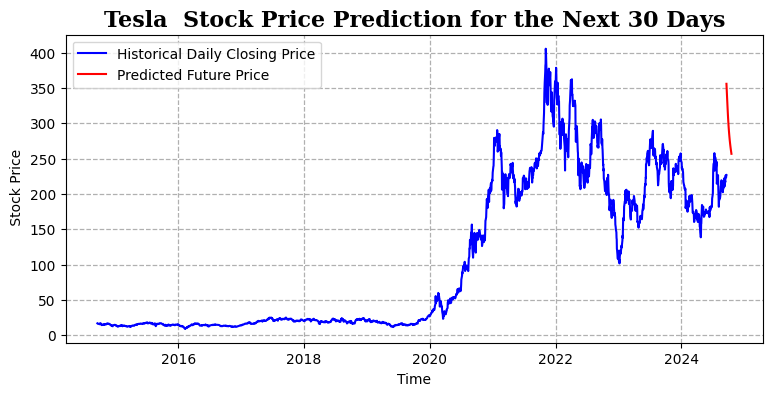

In [36]:
def plot_future_predictions(data, future_days,stock_name='Stock'):
    """
    Plots the predicted future prices along with historical data.

    Parameters:
    - data: Pandas DataFrame containing historical data with index as datetime
    - future_days: NumPy array containing predicted future prices

    Returns:
    - None
    """
    # Adjusting the dimensions of future_days array
    future_days = future_days.squeeze()

    # Plotting the predictions
    predicted_dates = pd.date_range(start=data.index[-1], periods=len(future_days))
    plt.figure(figsize=(9, 4))
    plt.plot(data.index, data['Close'], color='blue', label='Historical Daily Closing Price')
    plt.plot(predicted_dates, future_days, color='red', label='Predicted Future Price')
    plt.title(f'{stock_name}  Stock Price Prediction for the Next {len(future_days)} Days',
              fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel(' Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()
    plt.show()

# Example function call with actual data
# Replace data and future_days with your actual data
plot_future_predictions(data_tesla, future_days,'Tesla')

It is showing an upward trend for next 30 days,which is a good news for potential investors.

In [37]:
# Create the time series data structure using tesla
look_back = 50
train_size = int(len(scaled_data) * 0.80)
train_data_jpm = scaled_data[:train_size]
test_data_jpm = scaled_data[train_size - look_back:]

train_generator_jpm = TimeseriesGenerator(train_data_jpm, train_data_jpm,
                                     length=look_back, batch_size=20)
test_generator_jpm = TimeseriesGenerator(test_data_jpm, test_data_jpm,
                                     length=look_back, batch_size=1)

In [38]:
# Call the function to split the data into input-output datasets
# with a time step of 50
time_step = 50
X_train,Y_train =  create_dataset(train_data_jpm,time_step)
X_test,Y_test =  create_dataset(test_data_jpm,time_step)

In [39]:
# Display the shapes of the training and testing datasets
print(X_train.shape)
print(X_test.shape)

(1961, 50)
(503, 50)


In [40]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1))
# Compile and fit LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_generator_jpm, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 1/99 ━━━━━━━━━━━━━━━━━━━━ 6:21 4s/step - loss: 0.3349

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - loss: 0.0242 - val_loss: 0.0012
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - loss: 0.0017 - val_loss: 0.0060
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - loss: 0.0013 - val_loss: 9.0397e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - loss: 8.0601e-04 - val_loss: 0.0012
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 33s 144ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - loss: 7.2366e-04 - val_loss: 0.0021
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - loss: 5.7045e-04 - val_loss: 5.6352e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - loss: 8.8411e-04 - val_loss: 0.0107
Epoch 12/50
99/99 ━━━━━━━━━━

In [41]:
#  the  build GRU model
input_shape = (train_generator_jpm.length, 1)  # Assuming univariate time series
gru_model = build_gru_model(input_shape)

# Train the GRU model function call
gru_model.fit(train_generator_jpm, epochs=20, batch_size=32, validation_data=test_generator_jpm)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 0.0141 - val_loss: 7.2695e-04
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - loss: 3.2880e-04 - val_loss: 0.0016
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - loss: 7.5309e-04 - val_loss: 4.5476e-04
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - loss: 2.7867e-04 - val_loss: 6.6738e-04
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - loss: 3.1358e-04 - val_loss: 5.0628e-04
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - loss: 2.2922e-04 - val_loss: 3.5198e-04
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - loss: 8.6536e-04 - val_loss: 5.2073e-04
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - loss: 3.1540e-04 - val_loss: 2.3850e-04
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 2.2138e-04 - val_loss: 6.9077e-04
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 3.6207e-04 - val_loss: 3.2025e-04
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - l

In [42]:
input_shape = (train_generator_jpm.length, 1)  # Assuming univariate time series
rnn_model = build_rnn_model(input_shape)

# Train the RNN model
history = rnn_model.fit(train_generator_jpm,epochs=20,batch_size=32,
    validation_data=test_generator_jpm,
    verbose=1
)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.1390 - val_loss: 0.0444
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0102 - val_loss: 0.0016
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 8.7760e-04 - val_loss: 0.0020
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 7.8756e-04 - val_loss: 0.0014
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 7.3916e-04 - val_loss: 0.0038
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 7.0711e-04 - val_loss: 0.0024
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 7.8624e-04 - val_loss: 0.0014
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━

In [43]:
# Predicting on the dataset with our models
rnn_predictions = rnn_model.predict(test_generator_jpm)
lstm_predictions = lstm_model.predict(test_generator_jpm)
gru_predictions = gru_model.predict(test_generator_jpm)

# Inverting out models
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)

actual_prices = scaler.inverse_transform(test_data_jpm[look_back:])

504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step


In [44]:
vals1 = Y_test.reshape(-1, 1)
actual_values = scaler.inverse_transform(vals1)

In [45]:
#  function call
rnn_mse, rnn_mae, rnn_rmse = calculate_model_errors(actual_values, rnn_predictions)
lstm_mse, lstm_mae, lstm_rmse = calculate_model_errors(actual_values, lstm_predictions)
gru_mse, gru_mae, gru_rmse = calculate_model_errors(actual_values, gru_predictions)

print(f'Mean Squared Error of RNN Model: {rnn_mse}')
print(f'Mean Absolute Error of RNN Model: {rnn_mae}')
print(f'Root Mean Squared Error of RNN Model: {rnn_rmse}')

print(f'Mean Squared Error of LSTM Model: {lstm_mse}')
print(f'Mean Absolute Error of LSTM Model: {lstm_mae}')
print(f'Root Mean Squared Error of LSTM Model: {lstm_rmse}')

print(f'Mean Squared Error of GRU Model: {gru_mse}')
print(f'Mean Absolute Error of GRU Model: {gru_mae}')
print(f'Root Mean Squared Error of GRU Model: {gru_rmse}')

Mean Squared Error of RNN Model: 146.8332953131179
Mean Absolute Error of RNN Model: 9.041798054658518
Root Mean Squared Error of RNN Model: 12.117478917378726
Mean Squared Error of LSTM Model: 45.127675943695486
Mean Absolute Error of LSTM Model: 5.179986198534296
Root Mean Squared Error of LSTM Model: 6.717713594944003
Mean Squared Error of GRU Model: 33.85373840811742
Mean Absolute Error of GRU Model: 4.400817387872594
Root Mean Squared Error of GRU Model: 5.818396549575959


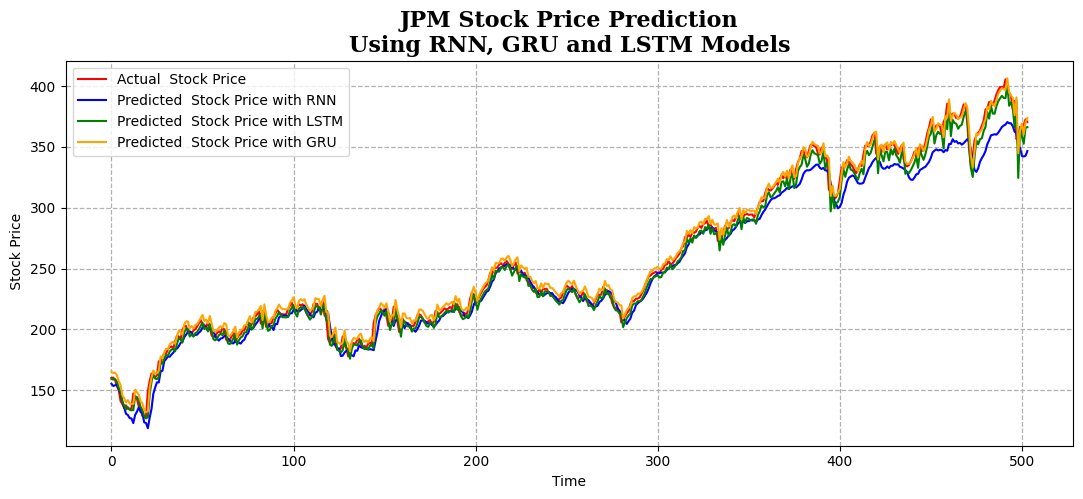

In [46]:
# Example function call with actual data
# Replace actual_prices, rnn_predictions, and lstm_predictions with your actual data
plot_predictions(actual_prices, rnn_predictions, lstm_predictions,gru_predictions,'JPM')

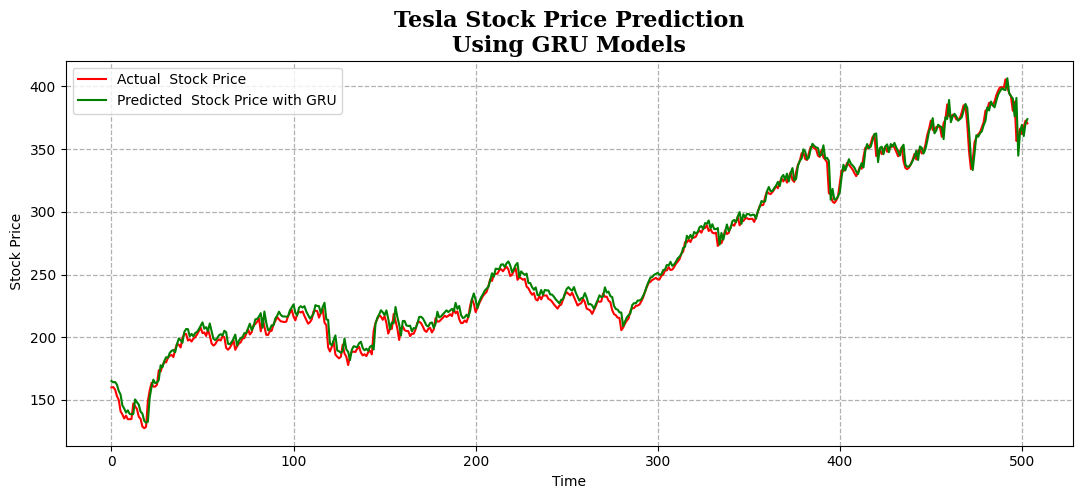

In [53]:
plot_predictions(actual_prices, gru_predictions,'Tesla')

In [47]:
# predicting the stock price by calling the function
days_to_pred = 30
future_days = pred_future_stock(lstm_model, scaled_data, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

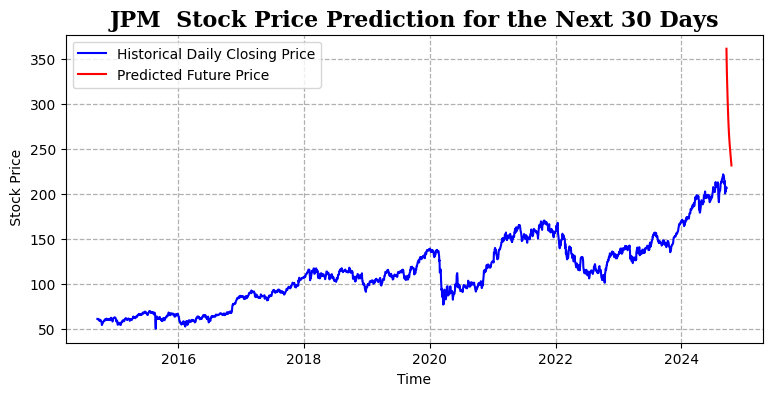

In [49]:
# Example function call with actual data
# Replace data and future_days with your actual data
plot_future_predictions(data, future_days,'JPM')